출처:https://www.kaggle.com/code/ashishpatel26/smote-with-model-lightgbm

### lightgbm(Light Gradient Boosting Machine):
 기계 학습을위한 무료 오픈 소스 분산 경사하강법(Gradient Boostiong) 프레임 워크
### tqdm
 실행 시간이 긴 코드에 대한 진행상황을 확인 가능하도록 하는 라이브러리
### dask
 병렬컴퓨팅을 위한 라이브러리
### gdbt : Traditional Gradient Boosting Decision Tree
 경사하강의사결정나무, 손실함수를 기반으로 오차를 줄여나가는 알고리즘
### rf : Random Forest
 랜덤 포레스트 
### dart : Dropouts meet Multiple Additive Regression Trees
 과적합을 방지하기 위해 사용 일부 데이터를 제외하고 학습시키는 알고리즘
### goss : Gradient-based One-Side Sampling

### dask.dataframe을 import 할 때 오류가 발생할 경우 아래 코드 실행
```
pip install dask[dataframe] --upgrade
```

In [1]:
pip install dask[dataframe] --upgrade

     |████████████████████████████████| 136 kB 13.5 MB/s 


In [2]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
import dask
import dask.dataframe as dd
import gc

from yellowbrick.text import TSNEVisualizer

%matplotlib inline
plt.style.use("fivethirtyeight")

import os
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities'))

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

['sample_submission.csv', 'test.csv', 'train.csv']


데이터 불러오기

In [3]:
def gc():
    print(gc.collect())


dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: 
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools,product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 gorizontalalignment="center",
                 color='white' if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
%%time
train = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities/train.csv',
                    blocksize = 256e6, dtype=dtypes)

CPU times: user 31.6 ms, sys: 9.48 ms, total: 41.1 ms
Wall time: 761 ms


In [5]:
%%time
test = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities/test.csv',
                    blocksize = 256e6, dtype=dtypes)
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_analysis/reducing-commercial-aviation-fatalities/test.csv',dtype=dtypes)

CPU times: user 62.9 ms, sys: 3.88 ms, total: 66.8 ms
Wall time: 1.26 s


In [6]:
%%time
train = train.compute()
print("Training shape : ", train.shape)

Training shape :  (4867421, 28)
CPU times: user 30.6 s, sys: 2.49 s, total: 33.1 s
Wall time: 44.9 s


In [7]:
%%time
test = test.compute()
print("Testing shape : ", test.shape)
# print(gc.collect())

Testing shape :  (17965143, 28)
CPU times: user 1min 47s, sys: 13.9 s, total: 2min 1s
Wall time: 2min 17s


In [8]:
train_df = train.copy()
test_df = test.copy()

In [9]:
import gc
gc.collect()

121

In [10]:
test_id = test_df['id']

dic = {'A': 0,'B':1,'C': 2, 'D':3}
dic1 = {'CA':0, 'DA':1, 'SS':3, 'LOFT':4}
train_df['event'] = train_df['event'].apply(lambda x:dic[x])
train_df['event'] = train_df['event'].astype('int8')
train_df['experiment'] = train_df['experiment'].apply(lambda x:dic1[x])
test_df['experiment'] = test_df['experiment'].apply(lambda x:dic1[x])

train_df['experiment'] = train_df['experiment'].astype('int8')
test_df['exdperiment'] = test_df['experiment'].astype('int8')

y = train_df['event']

In [11]:
tr_col = train_df.columns

In [12]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,exdperiment
0,0,1,4,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992,4
1,1,1,4,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001,4
2,2,1,4,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992,4
3,3,1,4,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001,4
4,4,1,4,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992,4


In [13]:
train_df.shape, test.shape

((4867421, 28), (17965143, 28))

#EDA

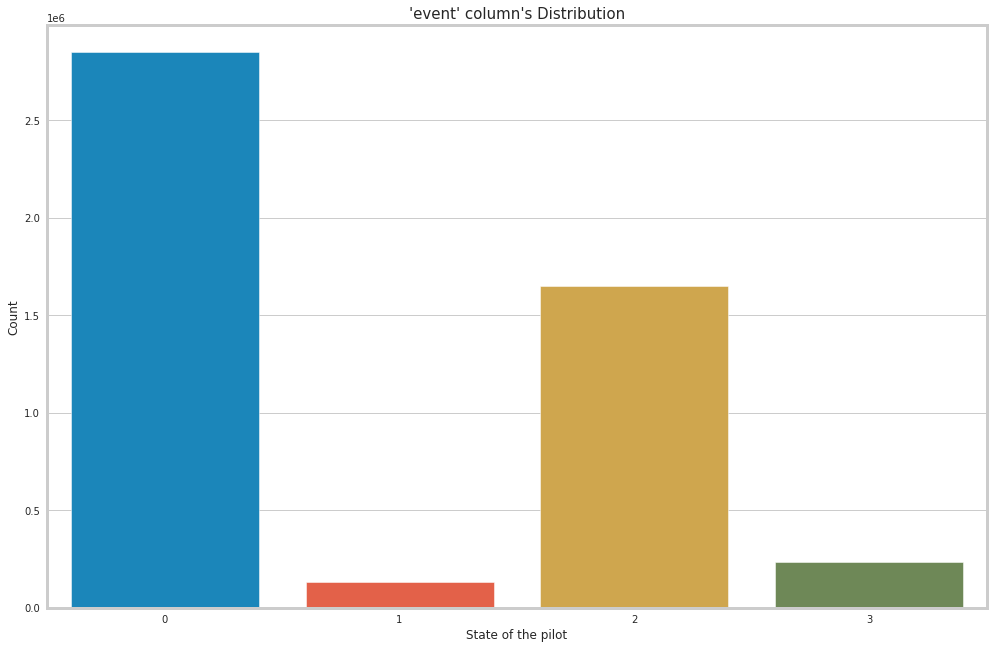

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(train_df['event'])
plt.xlabel('State of the pilot', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("'event' column's Distribution", fontsize=15)
plt.show()

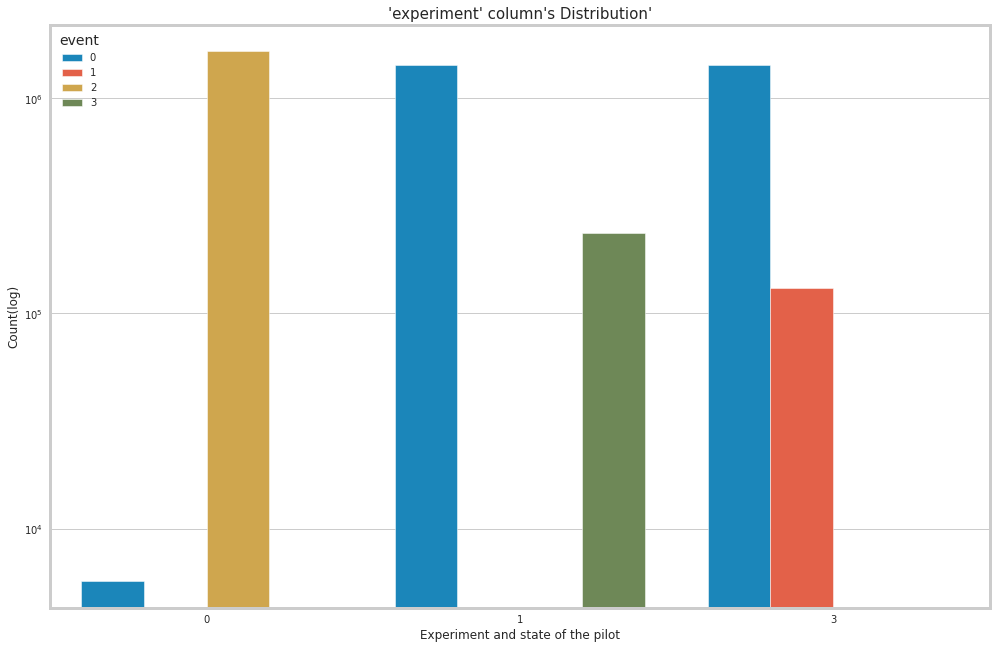

In [15]:
plt.figure(figsize=(15,10))
sns.countplot('experiment', hue='event', data=train_df)
plt.xlabel('Experiment and state of the pilot', fontsize=12)
plt.ylabel('Count(log)', fontsize=12)
plt.yscale('log')
plt.title("'experiment' column's Distribution'", fontsize=15)
plt.show()

### Seat

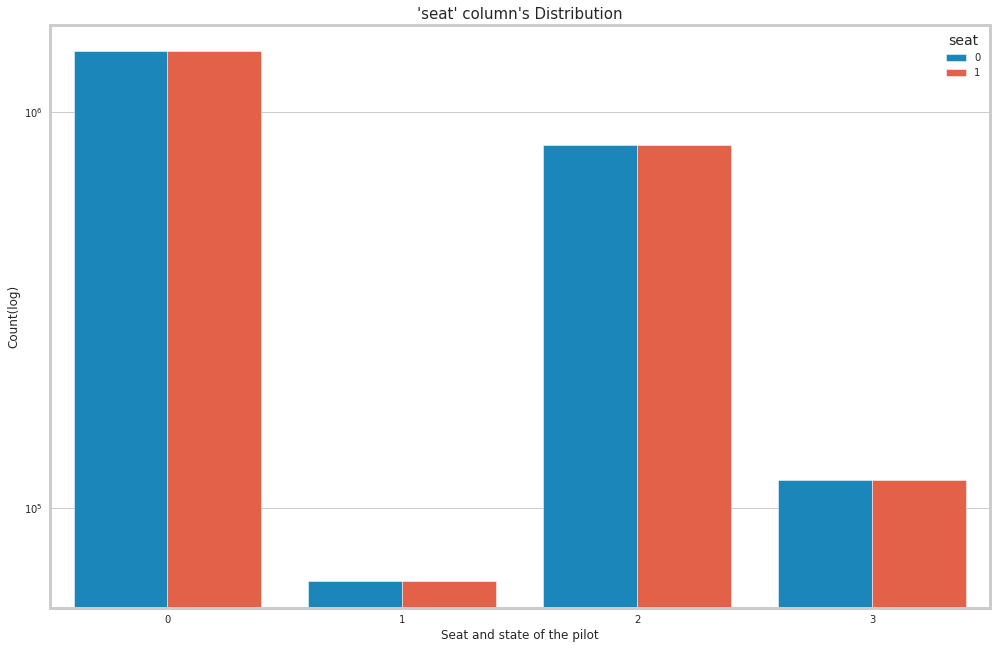

In [16]:
plt.figure(figsize=(15,10))
sns.countplot('event', hue='seat', data=train_df)
plt.xlabel('Seat and state of the pilot', fontsize=12)
plt.ylabel('Count(log)', fontsize=12)
plt.yscale('log')
plt.title("'seat' column's Distribution", fontsize=15)
plt.show()

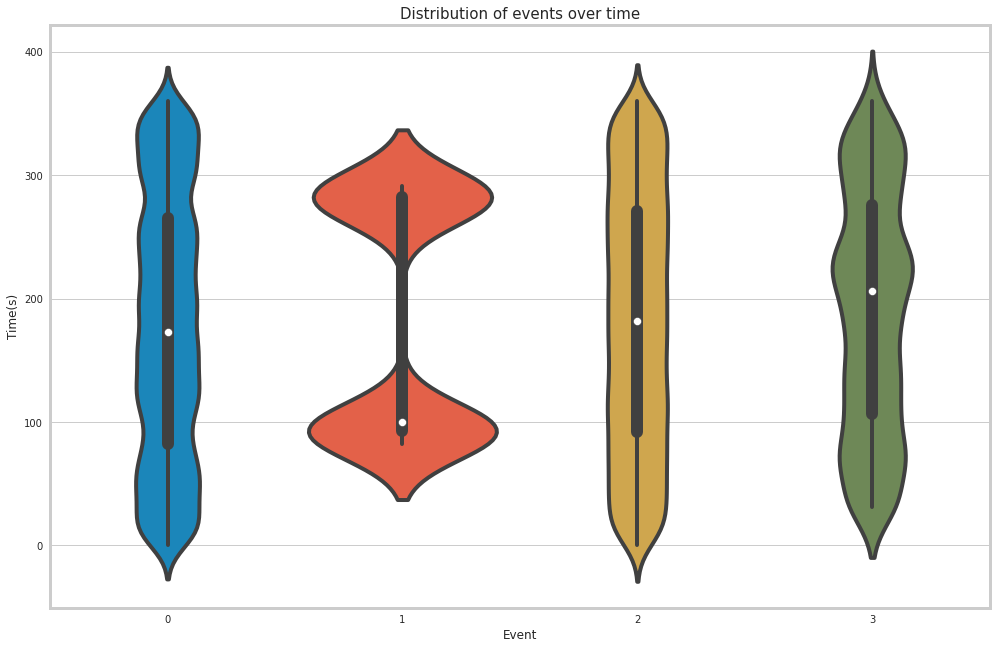

In [17]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event',y='time', data=train_df.sample(50000))
plt.xlabel('Event',fontsize=12)
plt.ylabel('Time(s)',fontsize=12)
plt.title('Distribution of events over time', fontsize= 15)
plt.show()

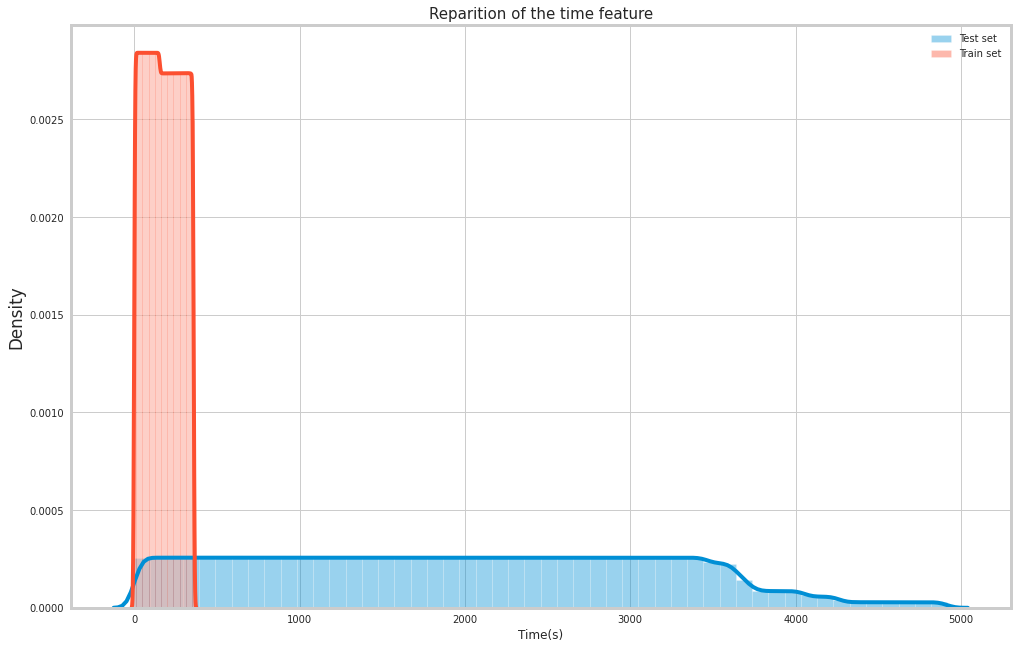

In [18]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['time'], label='Test set')
sns.distplot(train_df['time'], label='Train set')
plt.xlabel('Time(s)', fontsize=12)
plt.legend()
plt.title('Reparition of the time feature', fontsize=15)
plt.show()

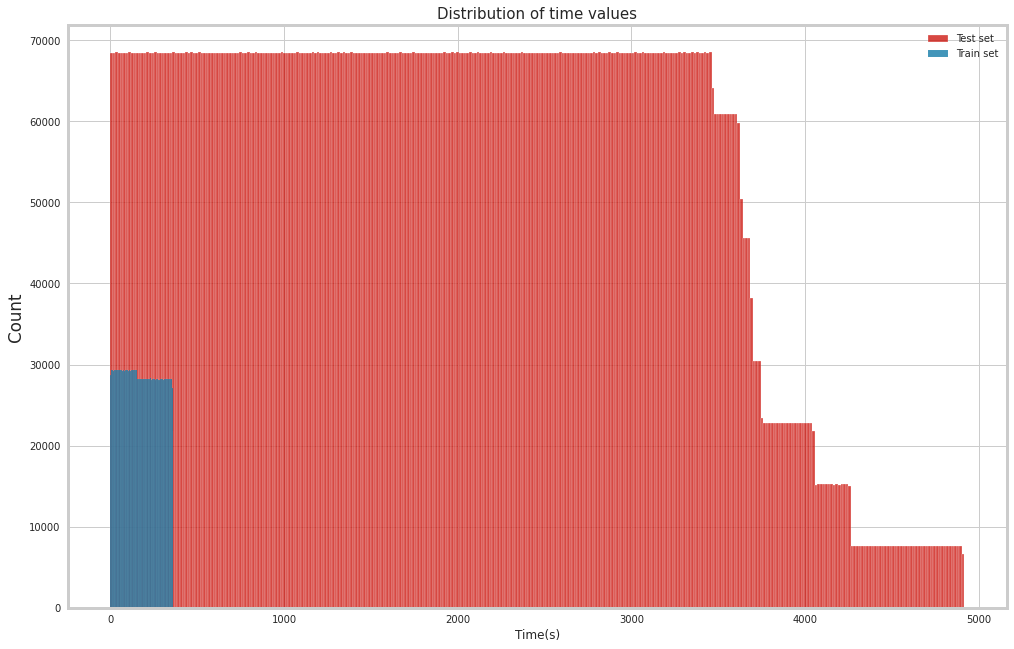

In [19]:
plt.figure(figsize=(15,10))
sns.histplot(test_df['time'], label='Test set', color='r')
sns.histplot(train_df['time'], label='Train set',color='b')
plt.xlabel('Time(s)', fontsize=12)
plt.legend()
plt.title('Distribution of time values', fontsize=15)
plt.show()

### EGG

In [20]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

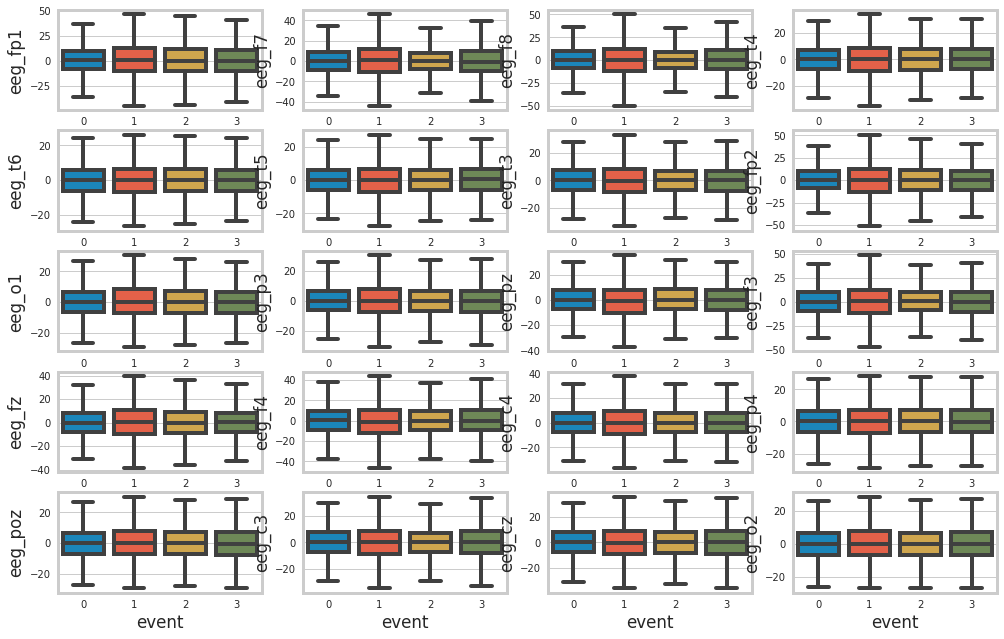

In [21]:
plt.figure(figsize=(15,10))
i = 0

for egg in eeg_features:
    i += 1
    plt.subplot(5,4,i)
    sns.boxplot(x='event', y=egg, data=train_df.sample(50000), showfliers=False)
plt.show()

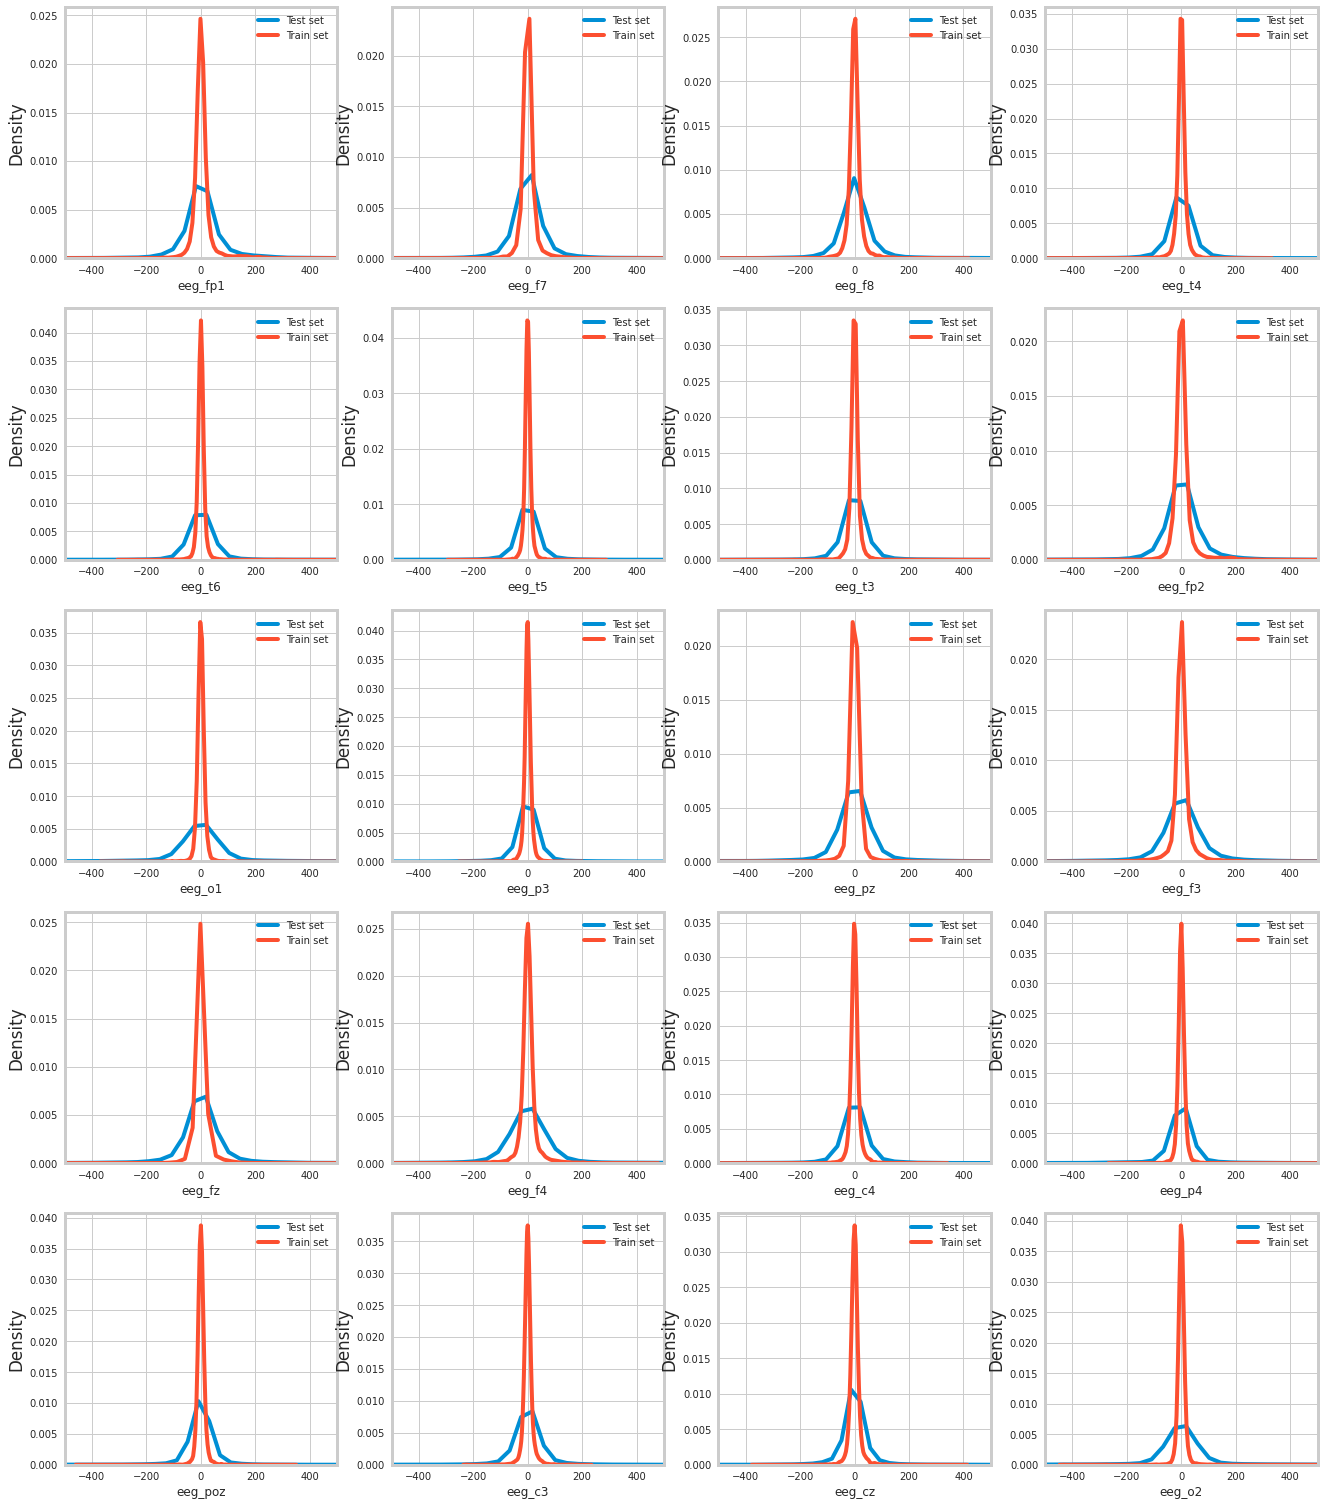

In [22]:
plt.figure(figsize=(20,25))
plt.title('Eeg features distributions')
i = 0

for eeg in eeg_features:
    i+=1
    plt.subplot(5,4,i)
    sns.distplot(test_df.sample(10000)[eeg], label='Test set', hist =False)
    sns.distplot(train_df.sample(10000)[eeg], label='Train set', hist=False)
    plt.xlim((-500, 500))
    plt.legend()
    plt.xlabel(eeg, fontsize=12)

plt.show()

###Electrocardiogram

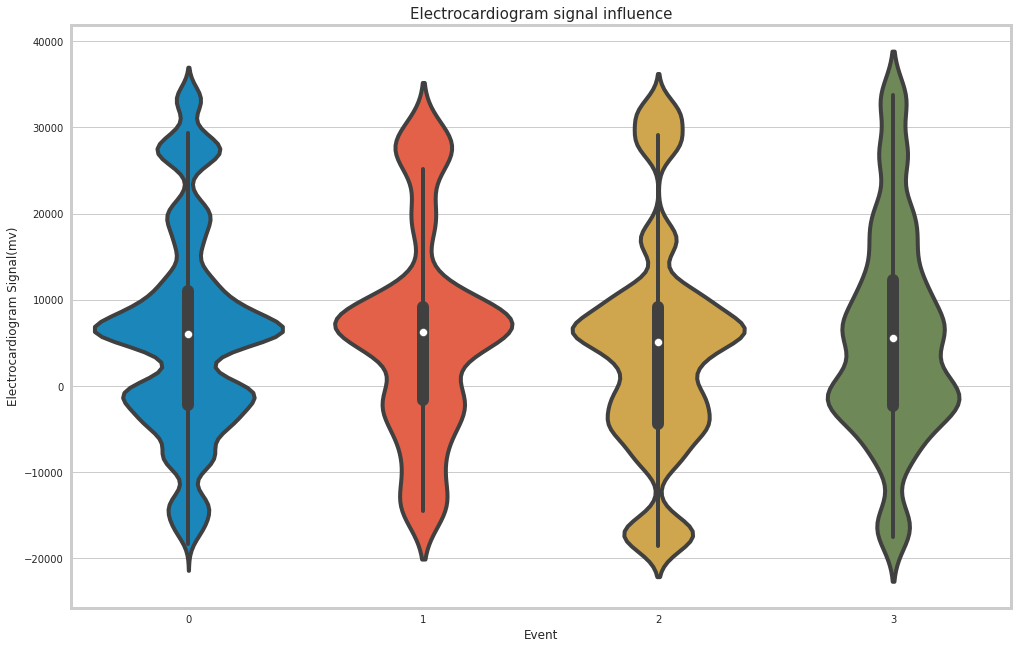

In [23]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event',y='ecg', data=train_df.sample(50000))
plt.ylabel('Electrocardiogram Signal(mv)', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.title('Electrocardiogram signal influence', fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['ecg'],label='Test set')
sns.distplot(train_df['ecg'],label='Train set')
plt.legend()
plt.xlabel('Electrocardiogram Signal(mv)', fontsize=12)
plt.title('Electrocardiogram Signal Distribution', fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(x='event', y='r', data=train_df.sample(50000))
plt.ylabel('Resiration Signal(mv)',fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.title('Respiration influence', fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(test_df['r'],label = 'Test set')
sns.distplot(train_df['r'],label = 'Train set')
plt.legend()
plt.xlabel('Respiration Signal (mv)', fontsize = 12)
plt.ylabel('Respiration Signal Distribution', fontsize = 12)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot('event','gsr', data=train_df.sample(50000))
plt.ylabel('Electrodermal activity measure (mv)', fontsize=12)
plt.xlabel('Event', fontsize=12)
plt.title('Electrodermal activity influence', fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize =(15,10))
sns.distplot(test_df['gsr'], label='Test set')
sns.distplot(train_df['gsr'], label='Train set')
plt.legend()
plt.xlabel('Electrodermal activity measure(mv)', fontsize = 12)
plt.title('Electrodermal activity Distribution', fontsize =15)
plt.show()

In [ ]:
train_df.shape, test_df.shape

In [ ]:
feature_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

In [ ]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']

print('Number of pilots : ', len(train_df['pilot'].unique()))

In [ ]:
train_df.shape, test_df.shape

In [ ]:
tr_col = train_df.columns

In [ ]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)
train_df = pd.DataFrame(train_df)
train_df.columns = tr_col
train.describe()

## Solve Class Imvalance Problem Using SMOTE
###SMOTE(synthetic minority oversampling technique)
 데이터의 수가 적은 클래스의 표본을 가져와 임의의 값을 추가하여 새로운 샘플을 만들어 데이터에 추가하는 오버샘플링 방식이다.
 데이터의 클래스 별 분포가 불균형할 때 사용하여 균형을 맞춘다.

In [ ]:
#train_df = normalize_by_pilots(train_df)
#test_df = normalize_by_pilots(test_df)
from imblearn.over_sampling import SMOTE
train_df, y = SMOTE().fit_resample(train_df, y.ravel())

In [ ]:
train_df.shape

In [ ]:
train_df = pd.DataFrame(train_df)
train_df.columns = tr_col
train_df.head()

### train 데이터와 test 데이터 나누기




In [ ]:
print(train_df.shape, test.shape)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=32)
print(f"Training on {train_df.shape[0]} samples.")

In [ ]:
features = ['crew','seat'] + features_n

def run_lgb(df_train, df_test):
    dic = {'A':0,'B':1,'C':2,'D':3}
    try:
        df_train['event'] = df_train["event"].apply(lambda x: dic[x])
        df_test['event'] = df_test['event'].apply(lambda x: dic[x])
    except:
        pass
    
    params = {'objective':'multiclass',
              'num_class': 4,
              'metric' : 'multi_error',
              'num_leaves' : 30,
              'min_child_weight' : 50,
              'learning_rate' : 0.1,
              'bagging_fraction' : 0.7,
              'reg_alpha' : 0.15,
              'reg_lambda' : 0.15,
              'min_child_weight' : 50,
              'bagging_seed' : 420,
              'verbosity' : -1}
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train['event']))
    lg_test = lgb.Dataset(df_test[features], label=(df_test['event']))
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50,verbose_eval=100)

    return model

In [ ]:
model = run_lgb(train_df, val_df)

### Feature importance

In [ ]:
fig,ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title('Importance of the Feature of our LightGBM Model', fontsize=15)
plt.show()

In [ ]:
pred_val = model.predict(val_df['features'],num_iteration=model.best_iteration)

In [ ]:
print('Log loss on validation data : ', round(log_loss(np.array(val_df['event'].values), pred_val),3))

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize = (15,10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(True)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thrash else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label', size = 12)
    plt.xlabel('Predicted label', size = 12)


In [ ]:
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df['event'].values) # 예측 감정와 실제 감정 사이 혼동행렬 계산
plot_confusion_matrix(conf_mat_val, ['A','B','C','D'], title='Confusion matrix on Validation data', nomalize=True) # 계산한 혼동행렬을 이용해 imshow(이미지맵) 생성

In [ ]:
pred_test = model.predict(test_df[features], num_iteration=model.best_iteration, data_has_header=False, is_reshape=True)

In [ ]:
submission = pd.DataFrame(np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), columns=['id','A','B','C','D'])
submission['id'] = submission['id'].astype(int)

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)